# Preparation work

In [1]:
!git clone https://github.com/vshokorov/power_laws_deep_ensembles.git

Cloning into 'power_laws_deep_ensembles'...
remote: Enumerating objects: 347, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 347 (delta 47), reused 58 (delta 36), pack-reused 275
Receiving objects: 100% (347/347), 58.40 MiB | 29.71 MiB/s, done.
Resolving deltas: 100% (189/189), done.


In [2]:
!pip install -q wandb
!pip install -q shap

     |████████████████████████████████| 1.8 MB 8.8 MB/s 
     |████████████████████████████████| 147 kB 69.5 MB/s 
     |████████████████████████████████| 181 kB 61.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 569 kB 5.2 MB/s 


In [3]:
import sys

wd_path = '/content/gdrive/MyDrive/Tanya_tasks/'

sys.path.append('power_laws_deep_ensembles')

In [4]:
import optimizer_utils

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import torch
import numpy as np
import models
import data
import utils
import gap_utils
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
from plot_utils import scatter_with_disp
from datetime import datetime
from multiprocessing import Pool
import torchvision
from PIL import Image
from data import Transforms as mytransforms
import torch.nn.functional as F
import pandas as pd
import shap
import warnings
# make a color map
from matplotlib.colors import LinearSegmentedColormap
import matplotlib

In [8]:
model_name = 'ResNet9'
architecture = getattr(models, model_name)()
architecture.kwargs['temperature'] = 1

model = architecture.base(num_classes=10, **architecture.kwargs)#.cuda()

model.load_state_dict(torch.load(wd_path + 'model_run0.cpt', map_location='cpu')['model_state'])
model.eval()

dataset = torchvision.datasets.SVHN('./data', download=True, split='test')
target_transform = mytransforms.SVHN.ResNet_9_noDA().train

  0%|          | 0/64275384 [00:00<?, ?it/s]

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as transform_F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs, figsize=None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        if isinstance(img, tuple):
            img, label = img
        else:
            label = ''
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        axs[0, i].set_title(str(label))


[10341 21456 24704  8555  7885  3296 21228 19190 13688  8713]


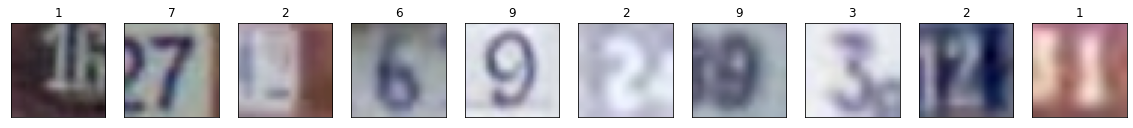

In [10]:
a = np.random.randint(0, len(dataset), 10)#[1774, 7570, 9213, 13851, 8671, 4116, 12724, 15143]

for i in range(1):#len(a) // 10):
    print(a[i*10:i*10 + 10])
    show([dataset[i] for i in a[i*10:i*10 + 10]], figsize=(20, 5))
    plt.show()

In [11]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


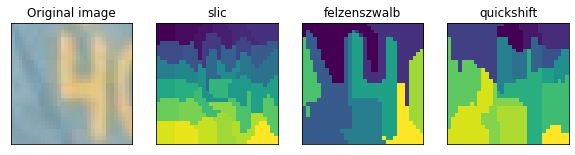

In [12]:
target_id = 10055
img_orig = np.array(dataset[target_id][0])

N = 40

fig, axs = plt.subplots(ncols=4, figsize=(10, 5))

axs[0].imshow(img_orig)
axs[0].set_title('Original image')
axs[1].imshow(slic(img_orig, n_segments=N, compactness=10, sigma=0.1))
axs[1].set_title('slic')
axs[2].imshow(felzenszwalb(img_orig, scale=10, sigma=0.1, min_size=40))
axs[2].set_title('felzenszwalb')
axs[3].imshow(quickshift(img_orig, kernel_size=1, max_dist=3, ratio=0.1))
axs[3].set_title('quickshift')

for i in range(4):
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


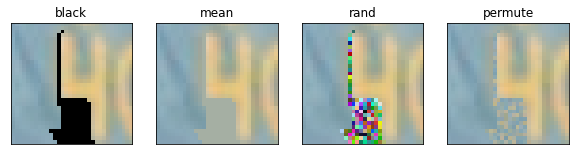

In [15]:
segmentation = felzenszwalb(img_orig, scale=10, sigma=0.1, min_size=40)
z = np.random.randint(0, segmentation.max(), (1, 25))


# matplotlib.rcParams.update({'font.size': 15})


res = []
for i in [0, 'mean', 'rand', 'permute']:
    res.append((mask_image(z, segmentation, img_orig, background=i)[0].astype(int), i if i != 0 else 'black'))

show(res, figsize=(10, 5))
plt.show()

# SHAP

In [14]:
def model_prediction(img):
    if isinstance(img, list):
        if isinstance(img[0], np.ndarray):
            img = [target_transform(_img) for _img in img]
        img = torch.vstack(img)
    elif isinstance(img, np.ndarray):
        if len(img.shape) == 3:
            img = target_transform(img)
            img.unsqueeze_(0)
        else:
            img = [target_transform(_img).unsqueeze(0) for _img in img]
            img = torch.vstack(img)
    
    with torch.no_grad():
        out = F.softmax(model(img.float()#.cuda()
                            ), 1).cpu().detach().numpy()
    return out

def mask_image(zs, segmentation, image, background=0):
    if background == 'mean':
        background = image.mean((0,1))
    elif background == 'black':
        background = 0
    elif background == 'white':
        background = 255
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                if background == 'rand':
                    out[i][segmentation == j,:] = np.random.rand(np.sum(segmentation == j) * image.shape[2]).reshape(-1, image.shape[2]) * 255
                elif background == 'permute':
                    idxs = np.random.permutation(np.sum(segmentation == j))
                    out[i][segmentation == j,:] = out[i][segmentation == j,:][idxs]
                else:
                    out[i][segmentation == j,:] = background
    return out
def f(z, segments, img_orig, background=0):
    mimg = mask_image(z, segments, img_orig, background)
    return model_prediction(mimg)

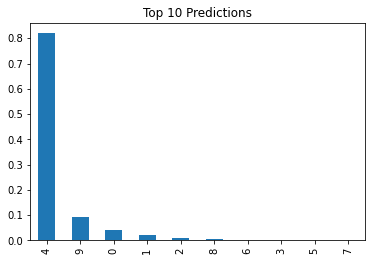

In [16]:
# get the top predictions from the model
preds = model_prediction(img_orig)
top_preds = np.argsort(-preds)
inds = top_preds[0]
top_10_pred=pd.Series(data={str(inds[i]):preds[0, inds[i]] for i in range(10)})
top_10_pred.plot(kind='bar', title='Top 10 Predictions')

In [17]:
# Visualize the explanations
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out
            
def explain_it(img, segment_generator, show=False):
    colors = []
    for l in np.linspace(1,0,100):
        colors.append((245/255,39/255,87/255,l))
    for l in np.linspace(0,1,100):
        colors.append((24/255,196/255,93/255,l))
    
    N = 40
    if segment_generator == 'slic':
        segments = slic(img, n_segments=N, compactness=10, sigma=0.1)
    elif segment_generator == 'felzenszwalb':
        segments = felzenszwalb(img, scale=10, sigma=0.1, min_size=40)
    elif segment_generator == 'quickshift':
        segments = quickshift(img, kernel_size=1, max_dist=3, ratio=0.1)
    else:
        raise

    cm = LinearSegmentedColormap.from_list("shap", colors)

    preds = F.softmax(model(target_transform(img_orig).unsqueeze(0).cuda()), 1).cpu().detach().numpy()
    top_preds = np.argsort(-preds)

    out = {}
    for background in ['black', 'mean', 'rand', 'permute']:
        explainer = shap.KernelExplainer(lambda x: f(x, segments, img, background), np.zeros((1,segments.max()+1)))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            
            shap_values = explainer.shap_values(np.ones((1,N)), nsamples=1000)
        
        # plot our explanations
        inds = top_preds[0]
        if show: 
            fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
            axes[0].imshow(img)
            axes[0].axis('off')
        max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
        
        out[background] = []
        for i in range(3):
            out[background].append([inds[i], shap_values[inds[i]][0]])
            if show: 
                m = fill_segmentation(shap_values[inds[i]][0], segments)
                axes[i+1].set_title(str(inds[i]))
                axes[i+1].imshow(img, alpha=0.15)
                im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
                axes[i+1].axis('off')
        if show: 
            cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
            cb.outline.set_visible(False)
            fig.suptitle(segment_generator + ', background: ' + str(background))
            plt.show()
    return segments, out

In [18]:
def get_mask_degradation(img_base, weights, label):
    weights = 1 - (weights - weights.min()) / (weights.max() - weights.min())
    # weights /= weights.std()
    out = []
    for l in np.linspace(0, 1, 100):
        new_img = np.clip(img_base - img_base * weights[...,None] * l, 0, 255).astype(np.uint8)
        out.append(model_prediction(new_img)[0][label])
        # print(np.isclose(new_img, img_base).all())
        # print(model_prediction(new_img)[0], l, np.max(img_base * weights[...,None] * l))
        # print(model_prediction(img_base)[0], l, np.max(img_base * weights[...,None] * l))
        # plt.imshow((img_base - img_base * weights[...,None] * l) / 255)
        # plt.axis('off')
        # plt.show()
    return out

In [19]:
def get_shap_degradation(img, segment_generator):
    segments, a = explain_it(img, segment_generator, False)
    out = {}
    for a_key in a:
        b = np.argsort(a[a_key][0][1])[::-1]
        z = np.ones((b.size+1, b.size))
        for i in range(1, b.size+1):
            z[i][b[:i]] = 0
        b = f(z, segments, img, background=a_key)
        # for i in mask_image(z, segments, img, a_key):
        #     plt.imshow(i / 255)
        #     plt.axis('off')
        #     plt.show()


        out[a_key] = b[:, a[a_key][0][0]]
    return a[a_key][0][0], out

In [ ]:
for segment_generator in ['slic', 'felzenszwalb', 'quickshift']:
    segments, a = explain_it(img_orig, segment_generator, False)
    m = 1 - fill_segmentation(a['black'][0][1], segments)
    plt.plot(get_mask_degradation(img_orig, m, a['black'][0][0]), label=segment_generator)
# plt.plot(get_mask_degradation(img_orig, - grayscale_cam, 4))
plt.legend()
plt.grid()
plt.xlabel('Shading value')
plt.ylabel('P(true class)')

In [ ]:
for segment_generator in ['slic']:#, 'felzenszwalb', 'quickshift']:
    c, a = get_shap_degradation(img_orig, segment_generator)
    for k in a:
        plt.plot(a[k], label=k)
    plt.legend()
    plt.grid()
    plt.xlabel('Shading value')
    plt.ylabel('P(true class)')
    plt.show()

10055 right answer: 4


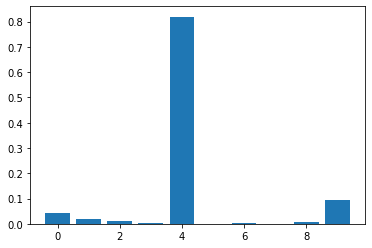

skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


  0%|          | 0/1 [00:00<?, ?it/s]

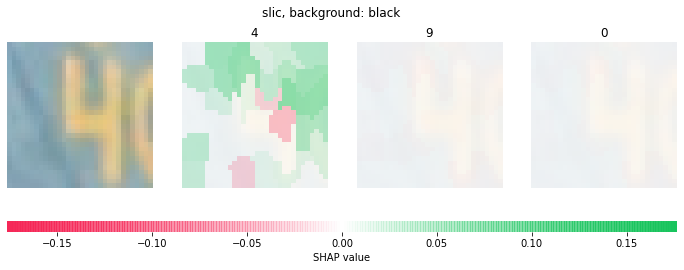

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  0%|          | 0/1 [00:00<?, ?it/s]

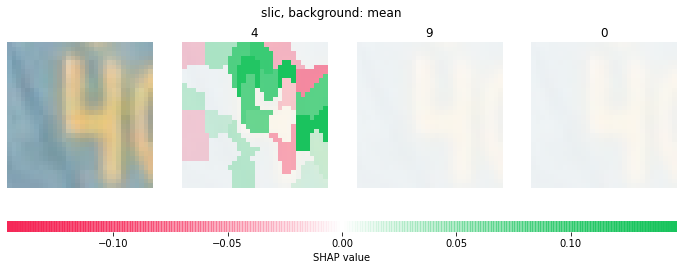

  0%|          | 0/1 [00:00<?, ?it/s]

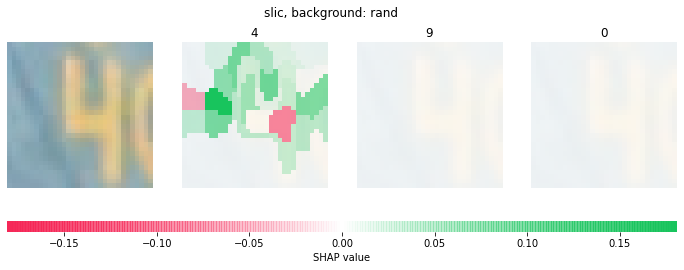

  0%|          | 0/1 [00:00<?, ?it/s]

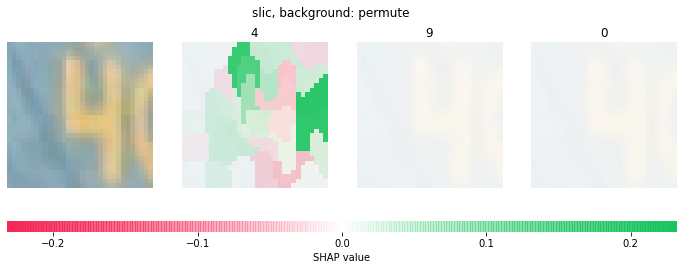

  0%|          | 0/1 [00:00<?, ?it/s]

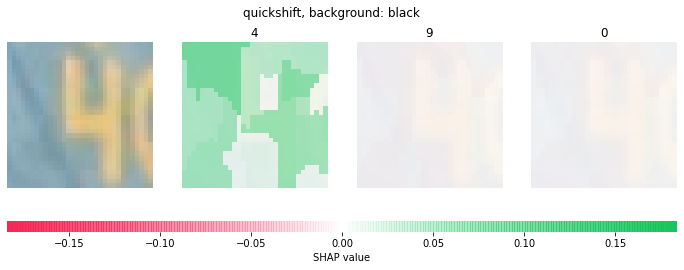

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  0%|          | 0/1 [00:00<?, ?it/s]

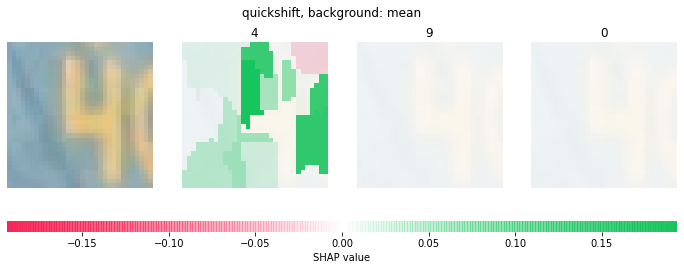

  0%|          | 0/1 [00:00<?, ?it/s]

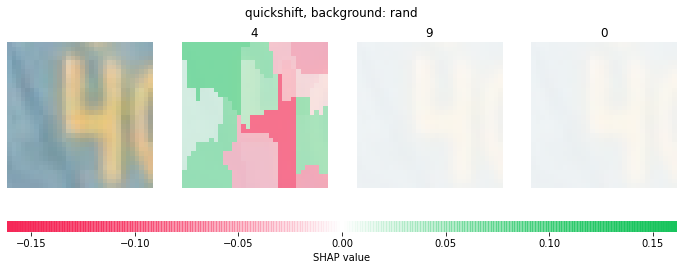

  0%|          | 0/1 [00:00<?, ?it/s]

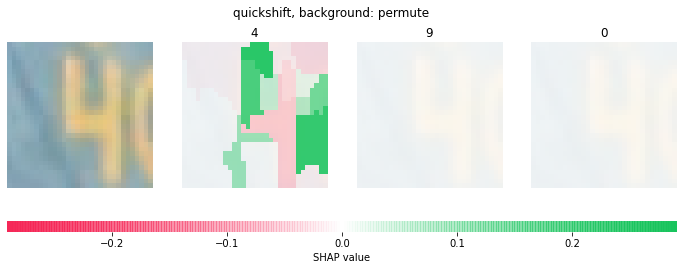

  0%|          | 0/1 [00:00<?, ?it/s]

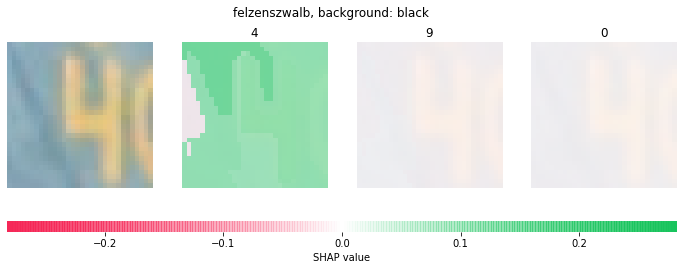

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  0%|          | 0/1 [00:00<?, ?it/s]

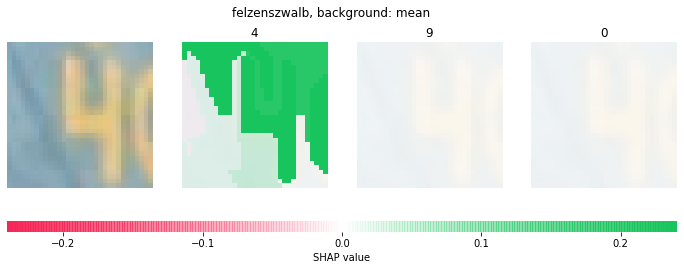

  0%|          | 0/1 [00:00<?, ?it/s]

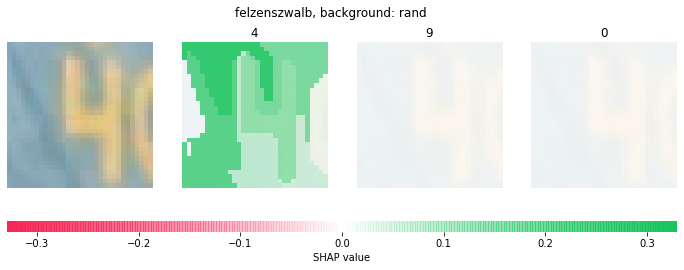

  0%|          | 0/1 [00:00<?, ?it/s]

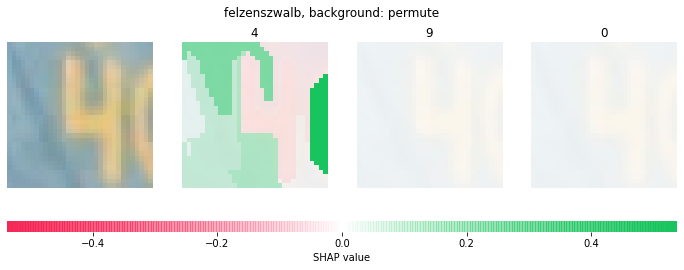

In [69]:
bad_ids = [10055]#, 14613, 15079, 35023, 36950, 18238, 2652] # bad
# bad_ids = [43419,  1774, 60375,  6672,  9978] # good

for target_id in bad_ids:
    print(target_id, 'right answer:', dataset[target_id][1])
    img_orig = np.array(dataset[target_id][0])

    plt.bar(range(10), model_prediction(img_orig)[0])
    plt.show()

    explain_it(img_orig, 'slic', True)
    explain_it(img_orig, 'quickshift', True)
    explain_it(img_orig, 'felzenszwalb', True)

# LIME

In [70]:
!pip install -q lime

     |████████████████████████████████| 275 kB 31.4 MB/s 


In [71]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

target_id = 10055
img_orig = np.array(dataset[target_id][0])

In [72]:
explanation = explainer.explain_instance(img_orig, model_prediction, #distance_metric = 'euclidean', 
                                         top_labels=5, num_samples=1000, )

  0%|          | 0/1000 [00:00<?, ?it/s]

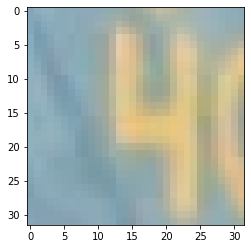

In [73]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=100, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

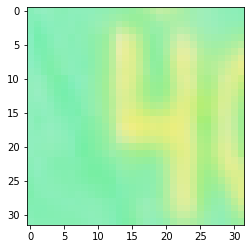

In [74]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=100, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

# Grad-cam

In [75]:
!pip install -q grad-cam

     |████████████████████████████████| 23.0 MB 339 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [76]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

target_id = 10055
img_orig = np.array(dataset[target_id][0])

Text(0.5, 1.0, 'Model answer: 3')

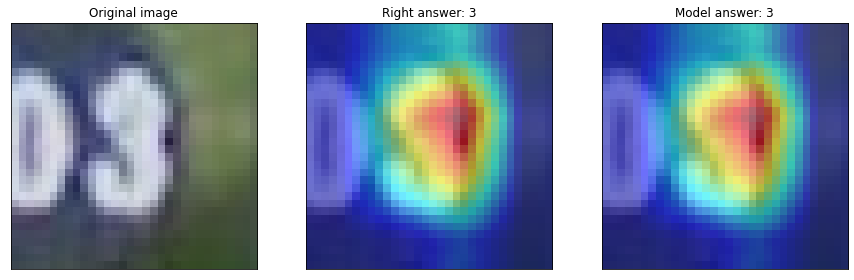

In [174]:
target_layers = [model.res2[-1]]
input_tensor = target_transform(img_orig).unsqueeze(0)# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].imshow(img_orig); axs[0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[0].set_title('Original image')


targets = [ClassifierOutputTarget(dataset[target_id][1])]
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
visualization = show_cam_on_image(img_orig / 255, grayscale_cam, use_rgb=True)
axs[1].imshow(visualization); axs[1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[1].set_title(f'Right answer: {targets[0].category}')

targets = [ClassifierOutputTarget(model_prediction(np.array(dataset[target_id][0]))[0].argmax())]
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
visualization = show_cam_on_image(img_orig / 255, grayscale_cam, use_rgb=True)
axs[2].imshow(visualization); axs[2].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
axs[2].set_title(f'Model answer: {targets[0].category}')

In [187]:
def get_mask_degradation(img_base, weights, label):
    # weights = 1 - (weights - weights.min()) / (weights.max() - weights.min())
    weights /= weights.std()
    out = []
    for l in np.linspace(0, 1, 100):
        new_img = np.clip(img_base - img_base * weights[...,None] * l, 0, 255).astype(np.uint8)
        out.append(model_prediction(new_img)[0][label])
        # print(np.isclose(new_img, img_base).all())
        # print(model_prediction(new_img)[0], l, np.max(img_base * weights[...,None] * l))
        # print(model_prediction(img_base)[0], l, np.max(img_base * weights[...,None] * l))
        # plt.imshow(new_img / 255)
        # plt.axis('off')
        # plt.show()
    return out

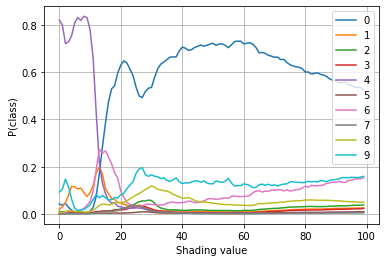

In [188]:
target_id = 10055
img_orig = np.array(dataset[target_id][0])

target_layers = [model.res2[-1]]
input_tensor = target_transform(img_orig).unsqueeze(0)# Create an input tensor image for your model..
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

targets = [ClassifierOutputTarget(dataset[target_id][1])]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

for i in range(10):
    plt.plot(get_mask_degradation(img_orig, grayscale_cam, i), label=str(i))#dataset[target_id][1]))
plt.legend()
plt.xlabel('Shading value')
plt.ylabel('P(class)')
plt.grid()
plt.show()

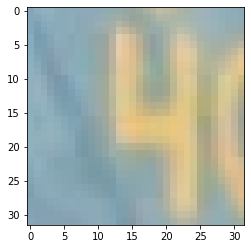

In [191]:
plt.imshow(img_orig)

In [192]:
model_prediction(img_orig), model_prediction(img_orig - 0.)

(array([[0.04319671, 0.01974849, 0.01068783, 0.00211139, 0.8193756 ,
         0.00108781, 0.00334417, 0.00093062, 0.00641965, 0.09309772]],
       dtype=float32),
 array([[0.0000000e+00, 1.2255451e-04, 6.3953077e-36, 0.0000000e+00,
         9.9987745e-01, 0.0000000e+00, 0.0000000e+00, 2.6962539e-14,
         4.4337083e-42, 1.6163149e-28]], dtype=float32))

In [202]:
target_transform

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [201]:
target_transform(img_orig.astype(float))

tensor([[[587.4017, 622.3362, 635.4367,  ..., 617.9694, 613.6026, 600.5022],
         [578.6681, 583.0349, 604.8690,  ..., 626.7031, 622.3362, 613.6026],
         [578.6681, 548.1004, 583.0349,  ..., 639.8035, 639.8035, 635.4367],
         ...,
         [569.9345, 565.5677, 565.5677,  ..., 696.5721, 762.0742, 849.4105],
         [578.6681, 565.5677, 569.9345,  ..., 666.0044, 705.3057, 775.1747],
         [596.1354, 578.6681, 578.6681,  ..., 644.1703, 661.6376, 692.2052]],

        [[730.1071, 765.8214, 788.1429,  ..., 774.7500, 765.8214, 752.4286],
         [734.5714, 739.0357, 765.8214,  ..., 770.2857, 765.8214, 756.8929],
         [739.0357, 712.2500, 752.4286,  ..., 770.2857, 765.8214, 752.4286],
         ...,
         [721.1786, 716.7143, 721.1786,  ..., 783.6786, 783.6786, 823.8571],
         [725.6429, 712.2500, 716.7143,  ..., 770.2857, 770.2857, 797.0714],
         [739.0357, 721.1786, 721.1786,  ..., 765.8214, 756.8929, 765.8214]],

        [[815.9733, 842.6400, 851.5289,  ...

In [197]:
target_transform(img_orig - 0.).dtype

torch.float64

In [203]:
import torchvision.transforms as transforms

In [208]:
transforms.ToTensor()(img_orig).dtype

torch.float32

In [211]:
target_transform

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [218]:
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(transforms.ToTensor()(img_orig)).mean((1, 2))

tensor([0.7180, 1.0367, 1.0386])

In [209]:
target_transform(img_orig - 0.)

tensor([[[587.4017, 622.3362, 635.4367,  ..., 617.9694, 613.6026, 600.5022],
         [578.6681, 583.0349, 604.8690,  ..., 626.7031, 622.3362, 613.6026],
         [578.6681, 548.1004, 583.0349,  ..., 639.8035, 639.8035, 635.4367],
         ...,
         [569.9345, 565.5677, 565.5677,  ..., 696.5721, 762.0742, 849.4105],
         [578.6681, 565.5677, 569.9345,  ..., 666.0044, 705.3057, 775.1747],
         [596.1354, 578.6681, 578.6681,  ..., 644.1703, 661.6376, 692.2052]],

        [[730.1071, 765.8214, 788.1429,  ..., 774.7500, 765.8214, 752.4286],
         [734.5714, 739.0357, 765.8214,  ..., 770.2857, 765.8214, 756.8929],
         [739.0357, 712.2500, 752.4286,  ..., 770.2857, 765.8214, 752.4286],
         ...,
         [721.1786, 716.7143, 721.1786,  ..., 783.6786, 783.6786, 823.8571],
         [725.6429, 712.2500, 716.7143,  ..., 770.2857, 770.2857, 797.0714],
         [739.0357, 721.1786, 721.1786,  ..., 765.8214, 756.8929, 765.8214]],

        [[815.9733, 842.6400, 851.5289,  ...